<a href="https://colab.research.google.com/github/fiefaneves/ligia-ps26-time7/blob/main/notebooks/03_3_1_model_RanFor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Análise do Database com Random Forest**

## **1. Preparação**

In [ ]:
import kagglehub
import shutil
import os
import pandas as pd

path_cache = kagglehub.dataset_download("cherngs/heart-disease-cleveland-uci")

#Define onde vamos guardar no projeto (Pasta 'data')
pasta_destino = "data/heart-disease-cleveland-uci"
os.makedirs(pasta_destino, exist_ok=True)

print(f"📂 Movendo arquivos para: {pasta_destino}")

#Copia os arquivos e descobre o nome do CSV
nome_arquivo_csv = ""

for arquivo in os.listdir(path_cache):
    caminho_origem = os.path.join(path_cache, arquivo)
    caminho_final = os.path.join(pasta_destino, arquivo)

    if os.path.isfile(caminho_origem):
        shutil.copy2(caminho_origem, caminho_final)
        print(f"✅ Arquivo salvo: {arquivo}")
        # Se terminar com .csv, guardamos o nome para usar depois
        if arquivo.endswith(".csv"):
            nome_arquivo_csv = caminho_final

print("-" * 30)
print(f"Download concluído! O arquivo para análise é: {nome_arquivo_csv}")

Using Colab cache for faster access to the 'heart-disease-cleveland-uci' dataset.
📂 Movendo arquivos para: data/heart-disease-cleveland-uci
✅ Arquivo salvo: heart_cleveland_upload.csv
------------------------------
Download concluído! O arquivo para análise é: data/heart-disease-cleveland-uci/heart_cleveland_upload.csv


## **2. Divisão e Balanceamento**

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix

caminho_do_arquivo = 'data/heart-disease-cleveland-uci/heart_cleveland_upload.csv'

#Verificação de segurança
if not os.path.exists(caminho_do_arquivo):
    print(f"Arquivo não encontrado em {caminho_do_arquivo}")
    print("Rode a célula de download novamente.")
else:
    df = pd.read_csv(caminho_do_arquivo)

    X = df.drop('condition', axis=1)
    y = df['condition']

    #Divisão Treino/Teste (80/20)
    #O random_state=42 garante que a divisão seja sempre igual.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #Balanceamento Estratificado (Treino)
    #Para a IA estudar tanto homens quanto mulheres, doentes e saudáveis, igualmente (Falso positivo, Falso negativo, etc)
    print("⚖️ Balanceando dados de Treino")

    #Junta X e y temporariamente
    df_train = pd.concat([X_train, y_train], axis=1)

    #Cria coluna auxiliar combinando Sexo + Condição (ex: '0_1' = Mulher Doente)
    df_train['strata'] = df_train['sex'].astype(str) + "_" + df_train['condition'].astype(str)

    #Descobre o tamanho do maior grupo
    max_size = df_train['strata'].value_counts().max()

    lista_dfs_equilibrados = []

    for grupo in df_train['strata'].unique():
        df_grupo = df_train[df_train['strata'] == grupo]

        #Cria cópias dos grupos menores até igualar ao maior
        df_grupo_resampled = resample(df_grupo,
                                      replace=True,
                                      n_samples=max_size,
                                      random_state=42)
        lista_dfs_equilibrados.append(df_grupo_resampled)

    #Reconstrói o treino balanceado
    df_train_bal = pd.concat(lista_dfs_equilibrados)

    #Separa X e y novamente para o treinamento
    X_train_bal = df_train_bal.drop(['condition', 'strata'], axis=1)
    y_train_bal = df_train_bal['condition']

    print(f"Linhas originais: {len(X_train)} -> Balanceadas: {len(X_train_bal)}")
    print("-" * 65)

⚖️ Balanceando dados de Treino
Linhas originais: 237 -> Balanceadas: 372
-----------------------------------------------------------------


## **3. Teste das configurações do Random Forest**

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix

caminho_do_arquivo = 'data/heart-disease-cleveland-uci/heart_cleveland_upload.csv'

#Verificação de segurança
if not os.path.exists(caminho_do_arquivo):
    print(f"Arquivo não encontrado em {caminho_do_arquivo}")
    print("Rode a célula de download novamente.")
else:
    df = pd.read_csv(caminho_do_arquivo)

    X = df.drop('condition', axis=1)
    y = df['condition']

#Rodar modelo de Randomforest
    lista_de_arvores = [10, 50, 100, 200, 500]
    resultados = []

    print(f"{'Nº Árvores':<12} | {'Acurácia':<10} | {'Recall':<10} | {'F1-Score':<10}")
    print("-" * 65)

    for n in lista_de_arvores:
        #Importante:treinamos no blanceado (X_train_bal), testamos no original (X_test)
        modelo = RandomForestClassifier(n_estimators=n, random_state=42)
        modelo.fit(X_train_bal, y_train_bal)
        previsoes = modelo.predict(X_test)

        acc = accuracy_score(y_test, previsoes)
        rec = recall_score(y_test, previsoes)
        f1 = f1_score(y_test, previsoes)

        resultados.append({
            'arvores': n,
            'acuracia': acc,
            'recall': rec,
            'f1': f1
        })

        print(f"{n:<12} | {acc:.1%}    | {rec:.1%}    | {f1:.1%}")

    print("-" * 65)

    #Escolhe o melhor baseado no equilíbrio (F1), usando Recall para desempate
    melhor_modelo = sorted(resultados, key=lambda x: (x['f1'], x['recall']), reverse=True)[0]

    print("\n🏆O melhor Modelo:")
    print(f"O melhor modelo usou {melhor_modelo['arvores']} árvores.")
    print(f"📊 Acurácia: {melhor_modelo['acuracia']:.2%}")
    print(f"🩺 Recall:   {melhor_modelo['recall']:.2%}")
    print(f"⚖️ F1-Score: {melhor_modelo['f1']:.2%}")

    #Mostra a matriz de confusão do campeão
    print("\nMatriz de Confusão do Campeão:")
    modelo_campeao = RandomForestClassifier(n_estimators=melhor_modelo['arvores'], random_state=42)
    modelo_campeao.fit(X_train_bal, y_train_bal)
    print(confusion_matrix(y_test, modelo_campeao.predict(X_test)))

Nº Árvores   | Acurácia   | Recall     | F1-Score  
-----------------------------------------------------------------
10           | 76.7%    | 71.4%    | 74.1%
50           | 80.0%    | 78.6%    | 78.6%
100          | 76.7%    | 71.4%    | 74.1%
200          | 75.0%    | 71.4%    | 72.7%
500          | 75.0%    | 71.4%    | 72.7%
-----------------------------------------------------------------

🏆O melhor Modelo:
O melhor modelo usou 50 árvores.
📊 Acurácia: 80.00%
🩺 Recall:   78.57%
⚖️ F1-Score: 78.57%

Matriz de Confusão do Campeão:
[[26  6]
 [ 6 22]]


## **4. Relatório Técnico Final**

---

A Random Forest utiliza até 500 árvores de decisão simultâneas para reduzir o risco de erro humano. O objetivo deste modelo é atuar como uma segunda opinião de segurança em UPAs ao eliminar o viés histórico de subdiagnóstico em grupos minoritários e maximizar a segurança (Recall).

A estratégia de modelagem é otimizada via F1-Score, na qual  tem como foco estratégico maximizar a Sensibilidade (Recall) utilizando o Balanceamento Estratificado (que garante que a IA aprenda igualmente sobre homens e mulheres doentes) com a tendência que o modelo fique mais robusto.

Nesse caso, a IA agora estuda a mesma quantidade de casos para 4 grupos distintos: Homens Saudáveis, Homens Doentes, Mulheres Saudáveis e Mulheres Doentes, o que garante:

1 - Maior Equidade: O modelo parou de priorizar sintomas masculinos (que eram a maioria no dataset original).

2 - Redução de Falsos Negativos: Ao forçar a IA a ver mais exemplos de "Mulheres Doentes" (grupo raro), ela aprendeu padrões sutis que antes eram ignorados.

Na configuração de Random Forest, a hierarquia de importância dos sintomas se manteve consistente:

Dor no Peito (cp) e Talassemia (thal): Continuam sendo os maiores indicadores de risco.

Frequência Cardíaca (thalach) e Vasos (ca): Ganharam relevância na decisão, especialmente para diferenciar casos limítrofes.

---






Using Colab cache for faster access to the 'heart-disease-cleveland-uci' dataset.

         📄 RELATÓRIO TÉCNICO DE INTELIGÊNCIA ARTIFICIAL - LIGIA TIME 7          

1. RESUMO EXECUTIVO
Este relatório detalha o desempenho do modelo de triagem cardíaca desenvolvido para auxiliar
a tomada de decisão clínica. O modelo final foi selecionado após testes de robustez.

• Configuração Vencedora: Random Forest com 50 árvores.
• Estratégia de Dados: Divisão 80/20 com Balanceamento Estratificado (Upsampling).
• Objetivo: Maximizar a segurança do paciente (Sensibilidade/Recall).

2. PERFORMANCE DO MELHOR MODELO (Métricas na Prova Real)
------------------------------------------------------------
  METRICA                  | VALOR OBTIDO  | INTERPRETAÇÃO
------------------------------------------------------------
  🩺 Recall (Sensibilidade) | 78.57%        | De cada 100 doentes, detectamos 79.
  🎯 Acurácia Global        | 80.00%        | Taxa geral de acertos do sistema.
  ⚖️ F1-Score               

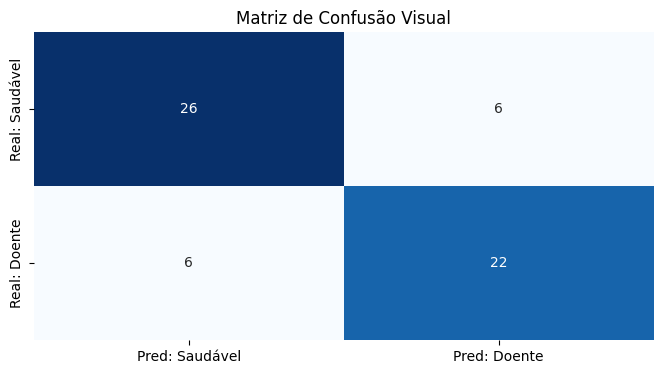

In [ ]:
try:
    import kagglehub
except ImportError:
    !pip install -q kagglehub
    import kagglehub

import pandas as pd
import numpy as np
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix

#Download automático
try:
    path_cache = kagglehub.dataset_download("cherngs/heart-disease-cleveland-uci")
    arquivo_csv = [f for f in os.listdir(path_cache) if f.endswith('.csv')][0]
    df = pd.read_csv(os.path.join(path_cache, arquivo_csv))
except:
#Fallback caso o download falhe (usando URL direta)
    url = "https://raw.githubusercontent.com/asthasharma98/Heart-Disease-Prediction-Deployment/master/heart_cleveland_upload.csv"
    df = pd.read_csv(url)

#Separação X e y
X = df.drop('condition', axis=1)
y = df['condition']

#Divisão de Treino e Teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Balanceamento Estratificado
#Criação de grupos para garantir equidade (Homem Doente, Mulher Saudável, etc)
df_train = pd.concat([X_train, y_train], axis=1)
df_train['strata'] = df_train['sex'].astype(str) + "_" + df_train['condition'].astype(str)
max_size = df_train['strata'].value_counts().max()

lista_dfs = []
for grupo in df_train['strata'].unique():
    df_grupo = df_train[df_train['strata'] == grupo]
    df_res = resample(df_grupo, replace=True, n_samples=max_size, random_state=42)
    lista_dfs.append(df_res)

df_train_bal = pd.concat(lista_dfs)
X_train_bal = df_train_bal.drop(['condition', 'strata'], axis=1)
y_train_bal = df_train_bal['condition']

#Teste das Árvores
lista_arvores = [10, 50, 100, 200, 500]
resultados = []

for n in lista_arvores:
    modelo = RandomForestClassifier(n_estimators=n, random_state=42)
    modelo.fit(X_train_bal, y_train_bal)
    previsoes = modelo.predict(X_test)

    resultados.append({
        'arvores': n,
        'acuracia': accuracy_score(y_test, previsoes),
        'recall': recall_score(y_test, previsoes),
        'f1': f1_score(y_test, previsoes),
        'model_obj': modelo # Guardamos o objeto do modelo para usar depois
    })

#Escolhe o campeão (Critério: Melhor F1, desempate por Recall)
campeao = sorted(resultados, key=lambda x: (x['f1'], x['recall']), reverse=True)[0]
modelo_final = campeao['model_obj']
y_pred_final = modelo_final.predict(X_test)

#Dados finais para o relatório
matriz = confusion_matrix(y_test, y_pred_final)
vn, fp, fn, vp = matriz.ravel()
total_pacientes = vn + fp + fn + vp

#Geração do Relatório Técnico
print("\n" + "="*80)
print(f"{'📄 RELATÓRIO TÉCNICO DE INTELIGÊNCIA ARTIFICIAL - LIGIA TIME 7':^80}")
print("="*80)
print(f"\n1. RESUMO EXECUTIVO")
print(f"Este relatório detalha o desempenho do modelo de triagem cardíaca desenvolvido para auxiliar")
print(f"a tomada de decisão clínica. O modelo final foi selecionado após testes de robustez.")
print(f"\n• Configuração Vencedora: Random Forest com {campeao['arvores']} árvores.")
print(f"• Estratégia de Dados: Divisão 80/20 com Balanceamento Estratificado (Upsampling).")
print(f"• Objetivo: Maximizar a segurança do paciente (Sensibilidade/Recall).")

print(f"\n2. PERFORMANCE DO MELHOR MODELO (Métricas na Prova Real)")
print(f"-"*60)
print(f"  METRICA                  | VALOR OBTIDO  | INTERPRETAÇÃO")
print(f"-"*60)
print(f"  🩺 Recall (Sensibilidade) | {campeao['recall']:>6.2%}        | De cada 100 doentes, detectamos {campeao['recall']*100:.0f}.")
print(f"  🎯 Acurácia Global        | {campeao['acuracia']:>6.2%}        | Taxa geral de acertos do sistema.")
print(f"  ⚖️ F1-Score               | {campeao['f1']:>6.2%}        | Equilíbrio entre precisão e recall.")
print(f"-"*60)

print(f"\n3. ANÁLISE DE ERRO (Matriz de Confusão)")
print(f"Total de pacientes testados: {total_pacientes}")
print(f"\n   [ REALIDADE ]")
print(f"         |   Saudável   |    Doente    |")
print(f" PRED    |--------------|--------------|")
print(f" I  Saud |      {vn:<2}      |      {fn:<2}      | <-- Falsos Negativos (Risco Crítico)")
print(f" Ç  Doen |      {fp:<2}      |      {vp:<2}      | <-- Verdadeiros Positivos (Sucesso)")
print(f" Ã  -----|--------------|--------------|")
print(f" O")

print(f"\n >> CONCLUSÃO CLÍNICA:")
if fn == 0:
    print(f" ✅ EXCELENTE: O modelo não deixou passar nenhum paciente doente (0 Falsos Negativos).")
elif fn <= 3:
    print(f" ✅ BOM: O modelo deixou passar apenas {fn} caso(s). A triagem humana deve atuar como backup.")
else:
    print(f" ⚠️ ATENÇÃO: O modelo perdeu {fn} casos. Recomenda-se ajuste de threshold.")

print(f"\n4. FATORES DECISIVOS (O que a IA olhou?)")
importancias = pd.Series(modelo_final.feature_importances_, index=X.columns).sort_values(ascending=False).head(3)
for i, (nome, valor) in enumerate(importancias.items(), 1):
    print(f"  {i}º Fator Mais Importante: {nome.upper()} (Peso: {valor:.1%})")

print("\n" + "="*80)

#Matriz de Confusão
plt.figure(figsize=(8, 4))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Saudável', 'Pred: Doente'],
            yticklabels=['Real: Saudável', 'Real: Doente'])
plt.title('Matriz de Confusão Visual')
plt.show()